In [1]:
import os
import pandas as pd
from glob import glob
from datetime import datetime
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

In [2]:
txt_dir = "word_lists/unrec_rel_words"
output_dir = "may30_output"
records = []

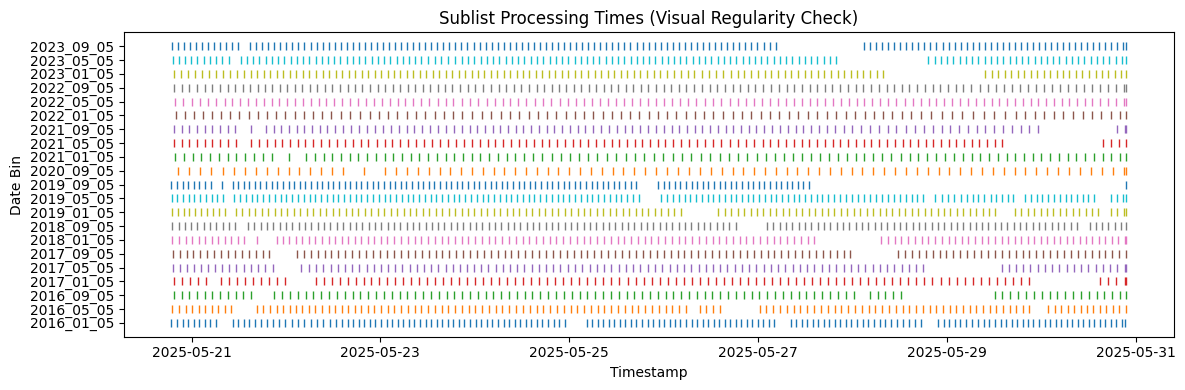

In [ ]:
for path in sorted(glob(f"{txt_dir}/*.txt")):
    date = os.path.basename(path).replace(".txt", "")
    txt_path = os.path.join(txt_dir, f"{date}.txt")
    out_path = os.path.join(output_dir, date)

    with open(txt_path) as f:
        wordlist = [line.strip() for line in f if line.strip()]
    total_words = len(wordlist)

    timestamp_file = os.path.join(out_path, "file_timestamps.csv")
    if not os.path.exists(timestamp_file):
        records.append({
            "Date": date,
            "Words": total_words,
            "Done": 0,
            "Words/Sub": None,
            "Filter/Rate": None,
            "Words Done": None,
            "Words Left": None,
            "AvgTime(s)": None
        })
        continue

    df = pd.read_csv(timestamp_file, header=None, names=["file", "timestamp"])
    df = df[~df["file"].str.contains("file_timestamps.csv")] 
    df["timestamp"] = pd.to_datetime(df["timestamp"])
    df = df.sort_values("timestamp")
    start_time = df["timestamp"].iloc[0] if not df.empty else None
    latest_upload = df["timestamp"].iloc[-1] if not df.empty else None

    done = len(df)
    avg_time = None
    if done >= 2:
        total_time = (df["timestamp"].iloc[-1] - df["timestamp"].iloc[0]).total_seconds()
        avg_time = total_time / (done - 1)

    word_counts = []
    for i in range(done):
        subfile = os.path.join(out_path, f"sublist_{i}.csv")
        if os.path.exists(subfile):
            try:
                sub_df = pd.read_csv(subfile)
                word_counts.append(len(sub_df))
            except:
                continue
    avg_words_per_sub = sum(word_counts) / len(word_counts) if word_counts else 10

    sublists = sorted(glob(os.path.join(out_path, "sublist_*.csv")))
    if sublists:
        try:
            last_sublist_num = max(int(os.path.basename(p).split('_')[1].split('.')[0]) for p in sublists)
            words_done = int((last_sublist_num + 1) * avg_words_per_sub)
        except:
            words_done = int(done * avg_words_per_sub)
    else:
        words_done = int(done * avg_words_per_sub)

    words_left = max(0, total_words - words_done)
    filter_rate = avg_words_per_sub / 10
    pred_word = words_left * filter_rate
    avg_time_per_word = avg_time / avg_words_per_sub if avg_time and avg_words_per_sub else None

    sub_durations = df["timestamp"].diff().dropna().dt.total_seconds()
    eta = eta_ci = eta_lower = eta_upper = time_std = None
    if len(sub_durations) >= 2:
        sem = stats.sem(sub_durations)
        ci_margin = 1.96 * sem
        avg_time_per_word_ci = ci_margin / avg_words_per_sub
        eta = pred_word * avg_time_per_word
        eta_ci = pred_word * avg_time_per_word_ci
        eta_lower = eta - eta_ci
        eta_upper = eta + eta_ci
        time_std = np.std(sub_durations)

    records.append({
        "Date": date,
        "Words": total_words,
        "Done": done,
        "Words/Sub": round(avg_words_per_sub, 2),
        "Filter/Rate": round(filter_rate, 4),
        "Words Done": words_done,
        "Words Left": words_left,
        "AvgTime(s)": round(avg_time, 2) if avg_time else None,
        "ETA": round(eta / 3600, 2) if eta else None,
        "ci": round(eta_ci / 3600, 2) if eta_ci else None,
        "ci_lower": round(eta_lower / 3600, 2) if eta_lower else None,
        "ci_upper": round(eta_upper / 3600, 2) if eta_upper else None,
        "time_std": round(time_std, 2) if time_std else None,
        "Start": start_time,
        "Latest_Upload": latest_upload

    })

df_summary = pd.DataFrame.from_records(records)
bad_dates = {"2015_01_05", "2015_05_05", "2015_09_05", "2018_05_05", "2020_01_05", "2020_05_05"}
df_summary = df_summary[~df_summary["Date"].isin(bad_dates)].reset_index(drop=True)
plt.figure(figsize=(12, 4))
for _, row in df_summary.iterrows():
    out_path = os.path.join(output_dir, row["Date"])
    timestamp_file = os.path.join(out_path, "file_timestamps.csv")
    if os.path.exists(timestamp_file):
        df = pd.read_csv(timestamp_file, header=None, names=["file", "timestamp"])
        df["timestamp"] = pd.to_datetime(df["timestamp"])
        plt.plot(df["timestamp"], [row["Date"]] * len(df), marker="|", linestyle="")

plt.title("Sublist Processing Times (Visual Regularity Check)")
plt.xlabel("Timestamp")
plt.ylabel("Date Bin")
plt.tight_layout()
plt.show()


In [4]:
df_summary

,Date,Words,Done,Words/Sub,Filter/Rate,Words Done,Words Left,AvgTime(s),ETA (hrs),ETA 95% CI (+/- hrs),ETA Lower (hrs),ETA Upper (hrs),Time Std (s),ETA,ci,ci_lower,ci_upper,time_std,Start,Latest_Upload
0,2016_01_05,1709,161,7.12,0.7119,1217.0,492.0,5435.56,NaN,NaN,NaN,NaN,NaN,74.29,3.87,70.41,78.16,1822.57,2025-05-20 18:53:16.218914051+00:00,2025-05-30 20:28:05.190990102+00:00
1,2016_05_05,2009,132,7.44,0.7442,1071.0,938.0,6613.52,NaN,NaN,NaN,NaN,NaN,172.32,14.45,157.87,186.77,3225.61,2025-05-20 19:09:28.531353693+00:00,2025-05-30 19:48:59.092220430+00:00
2,2016_09_05,2460,108,7.51,0.7505,923.0,1537.0,8092.63,NaN,NaN,NaN,NaN,NaN,345.51,62.40,283.11,407.91,7676.84,2025-05-20 19:29:28.793329999+00:00,2025-05-30 20:01:19.932809864+00:00
3,2017_01_05,2762,108,7.32,0.7320,885.0,1877.0,8130.69,NaN,NaN,NaN,NaN,NaN,423.93,59.26,364.66,483.19,5970.50,2025-05-20 19:31:10.071574423+00:00,2025-05-30 21:10:54.420505816+00:00
4,2017_05_05,2664,120,7.19,0.7189,963.0,1701.0,7317.64,NaN,NaN,NaN,NaN,NaN,345.76,52.78,292.98,398.54,6190.48,2025-05-20 19:16:42.338978561+00:00,2025-05-30 21:10:01.524383270+00:00
5,2017_09_05,2514,129,7.27,0.7269,1010.0,1504.0,6767.34,NaN,NaN,NaN,NaN,NaN,282.72,26.67,256.06,309.39,3669.86,2025-05-20 19:14:57.473666173+00:00,2025-05-30 19:51:57.345087916+00:00
6,2018_01_05,2519,132,7.13,0.7134,1034.0,1485.0,6652.00,NaN,NaN,NaN,NaN,NaN,274.39,34.77,239.63,309.16,4903.10,2025-05-20 19:09:34.809580849+00:00,2025-05-30 21:13:06.377502271+00:00
7,2018_09_05,2224,145,7.50,0.7496,1139.0,1085.0,6029.53,NaN,NaN,NaN,NaN,NaN,181.72,9.92,171.80,191.64,2008.39,2025-05-20 19:06:14.960991298+00:00,2025-05-30 20:17:07.634168989+00:00
8,2019_01_05,2034,141,7.33,0.7333,1107.0,927.0,6223.44,NaN,NaN,NaN,NaN,NaN,160.25,11.48,148.77,171.74,2682.31,2025-05-20 18:59:29.844432920+00:00,2025-05-30 21:00:51.398670879+00:00
9,2019_05_05,2009,157,7.39,0.7393,1227.0,782.0,5579.15,NaN,NaN,NaN,NaN,NaN,121.19,5.62,115.57,126.81,1643.37,2025-05-20 18:56:10.735782326+00:00,2025-05-30 20:41:58.275227688+00:00


In [5]:
bf = df_summary

In [6]:
bf["hours_used"] = (pd.Timestamp("2025-05-30 23:00", tz="UTC") - pd.to_datetime(bf["Start"])).dt.total_seconds() / 3600
bf["last_upload_hours"] = (pd.Timestamp("2025-05-30 23:00", tz="UTC")- pd.to_datetime(bf["Latest_Upload"])).dt.total_seconds() / 3600


In [7]:
bf

,Date,Words,Done,Words/Sub,Filter/Rate,Words Done,Words Left,AvgTime(s),ETA (hrs),ETA 95% CI (+/- hrs),...,Time Std (s),ETA,ci,ci_lower,ci_upper,time_std,Start,Latest_Upload,hours_used,last_upload_hours
0,2016_01_05,1709,161,7.12,0.7119,1217.0,492.0,5435.56,NaN,NaN,...,NaN,74.29,3.87,70.41,78.16,1822.57,2025-05-20 18:53:16.218914051+00:00,2025-05-30 20:28:05.190990102+00:00,244.112161,2.531891
1,2016_05_05,2009,132,7.44,0.7442,1071.0,938.0,6613.52,NaN,NaN,...,NaN,172.32,14.45,157.87,186.77,3225.61,2025-05-20 19:09:28.531353693+00:00,2025-05-30 19:48:59.092220430+00:00,243.842075,3.183585
2,2016_09_05,2460,108,7.51,0.7505,923.0,1537.0,8092.63,NaN,NaN,...,NaN,345.51,62.40,283.11,407.91,7676.84,2025-05-20 19:29:28.793329999+00:00,2025-05-30 20:01:19.932809864+00:00,243.508669,2.977796
3,2017_01_05,2762,108,7.32,0.7320,885.0,1877.0,8130.69,NaN,NaN,...,NaN,423.93,59.26,364.66,483.19,5970.50,2025-05-20 19:31:10.071574423+00:00,2025-05-30 21:10:54.420505816+00:00,243.480536,1.818217
4,2017_05_05,2664,120,7.19,0.7189,963.0,1701.0,7317.64,NaN,NaN,...,NaN,345.76,52.78,292.98,398.54,6190.48,2025-05-20 19:16:42.338978561+00:00,2025-05-30 21:10:01.524383270+00:00,243.721573,1.832910
5,2017_09_05,2514,129,7.27,0.7269,1010.0,1504.0,6767.34,NaN,NaN,...,NaN,282.72,26.67,256.06,309.39,3669.86,2025-05-20 19:14:57.473666173+00:00,2025-05-30 19:51:57.345087916+00:00,243.750702,3.134071
6,2018_01_05,2519,132,7.13,0.7134,1034.0,1485.0,6652.00,NaN,NaN,...,NaN,274.39,34.77,239.63,309.16,4903.10,2025-05-20 19:09:34.809580849+00:00,2025-05-30 21:13:06.377502271+00:00,243.840331,1.781562
7,2018_09_05,2224,145,7.50,0.7496,1139.0,1085.0,6029.53,NaN,NaN,...,NaN,181.72,9.92,171.80,191.64,2008.39,2025-05-20 19:06:14.960991298+00:00,2025-05-30 20:17:07.634168989+00:00,243.895844,2.714546
8,2019_01_05,2034,141,7.33,0.7333,1107.0,927.0,6223.44,NaN,NaN,...,NaN,160.25,11.48,148.77,171.74,2682.31,2025-05-20 18:59:29.844432920+00:00,2025-05-30 21:00:51.398670879+00:00,244.008377,1.985723
9,2019_05_05,2009,157,7.39,0.7393,1227.0,782.0,5579.15,NaN,NaN,...,NaN,121.19,5.62,115.57,126.81,1643.37,2025-05-20 18:56:10.735782326+00:00,2025-05-30 20:41:58.275227688+00:00,244.063685,2.300479


In [8]:
'''
us-west1-a
n1-highmem-8 => $0.4736/hr
NVIDIA T4 GPU => $0.35/hr
750GB disk space => $0.04/hr
cost-per-hour -> 0.8653

us-central1-a -> 0.8617/hr
'''


'\nus-west1-a\nn1-highmem-8 => $0.4736/hr\nNVIDIA T4 GPU => $0.35/hr\n750GB disk space => $0.04/hr\ncost-per-hour -> 0.8653\n\nus-central1-a -> 0.8617/hr\n'

In [18]:
bf['used_money'] = bf['hours_used'] * 0.8653
bf['est_cost'] = bf['ETA'] * 0.8653

In [19]:
bf["cost_ci"] = bf.apply(lambda row: f"${round(row.ci_lower * 0.8653, 2)} - ${round(row.ci_upper * 0.8653, 2)}", axis=1)

In [16]:
bf

,Date,Words,Done,Words/Sub,Filter/Rate,Words Done,Words Left,AvgTime(s),ETA (hrs),ETA 95% CI (+/- hrs),...,ci_lower,ci_upper,time_std,Start,Latest_Upload,hours_used,last_upload_hours,used_money,est_cost,cost_ci
0,2016_01_05,1709,161,7.12,0.7119,1217.0,492.0,5435.56,NaN,NaN,...,70.41,78.16,1822.57,2025-05-20 18:53:16.218914051+00:00,2025-05-30 20:28:05.190990102+00:00,244.112161,2.531891,211.230253,64.283137,$60.93 - $67.63
1,2016_05_05,2009,132,7.44,0.7442,1071.0,938.0,6613.52,NaN,NaN,...,157.87,186.77,3225.61,2025-05-20 19:09:28.531353693+00:00,2025-05-30 19:48:59.092220430+00:00,243.842075,3.183585,210.996547,149.108496,$136.6 - $161.61
2,2016_09_05,2460,108,7.51,0.7505,923.0,1537.0,8092.63,NaN,NaN,...,283.11,407.91,7676.84,2025-05-20 19:29:28.793329999+00:00,2025-05-30 20:01:19.932809864+00:00,243.508669,2.977796,210.708051,298.969803,$244.98 - $352.96
3,2017_01_05,2762,108,7.32,0.7320,885.0,1877.0,8130.69,NaN,NaN,...,364.66,483.19,5970.50,2025-05-20 19:31:10.071574423+00:00,2025-05-30 21:10:54.420505816+00:00,243.480536,1.818217,210.683708,366.826629,$315.54 - $418.1
4,2017_05_05,2664,120,7.19,0.7189,963.0,1701.0,7317.64,NaN,NaN,...,292.98,398.54,6190.48,2025-05-20 19:16:42.338978561+00:00,2025-05-30 21:10:01.524383270+00:00,243.721573,1.832910,210.892277,299.186128,$253.52 - $344.86
5,2017_09_05,2514,129,7.27,0.7269,1010.0,1504.0,6767.34,NaN,NaN,...,256.06,309.39,3669.86,2025-05-20 19:14:57.473666173+00:00,2025-05-30 19:51:57.345087916+00:00,243.750702,3.134071,210.917482,244.637616,$221.57 - $267.72
6,2018_01_05,2519,132,7.13,0.7134,1034.0,1485.0,6652.00,NaN,NaN,...,239.63,309.16,4903.10,2025-05-20 19:09:34.809580849+00:00,2025-05-30 21:13:06.377502271+00:00,243.840331,1.781562,210.995038,237.429667,$207.35 - $267.52
7,2018_09_05,2224,145,7.50,0.7496,1139.0,1085.0,6029.53,NaN,NaN,...,171.80,191.64,2008.39,2025-05-20 19:06:14.960991298+00:00,2025-05-30 20:17:07.634168989+00:00,243.895844,2.714546,211.043074,157.242316,$148.66 - $165.83
8,2019_01_05,2034,141,7.33,0.7333,1107.0,927.0,6223.44,NaN,NaN,...,148.77,171.74,2682.31,2025-05-20 18:59:29.844432920+00:00,2025-05-30 21:00:51.398670879+00:00,244.008377,1.985723,211.140448,138.664325,$128.73 - $148.61
9,2019_05_05,2009,157,7.39,0.7393,1227.0,782.0,5579.15,NaN,NaN,...,115.57,126.81,1643.37,2025-05-20 18:56:10.735782326+00:00,2025-05-30 20:41:58.275227688+00:00,244.063685,2.300479,211.188306,104.865707,$100.0 - $109.73


In [20]:
bf['used_money'].sum()

np.float64(4426.737443593978)

In [24]:
bf['est_cost'].sum()

np.float64(6493.929398999999)

In [25]:
bf['ci_lower'].sum() * 0.8653

np.float64(5919.586523999999)

In [26]:
bf['ci_upper'].sum() * 0.8653

np.float64(7068.272274)